# 🔮 Forecasting Meditation-Related Search Trends

This notebook adds a forecasting component to the project, extending beyond analysis into **predictive insights**.  
The dataset comes from Google Trends and tracks global weekly search interest for **meditation, mindfulness, breathwork, guided meditation, and yoga nidra**.  

A key strength is that this dataset is **kept up to date automatically** through the data pipeline I built earlier.  
That means the forecasts always reflect the latest search patterns, which demonstrates not just modeling skills but also automation and pipeline thinking.  

The goal here is not to build a highly complex forecasting system, but to show how time series methods like **Facebook Prophet** can be applied effectively to real-world data.  
By generating both **short-term (12 weeks)** and **long-term (52 weeks)** forecasts, I illustrate how interest in these practices may evolve in the months and year ahead.  

This section rounds out the project and highlights my ability to:  
- Clean and prepare time series data  
- Apply a forecasting model appropriately  
- Backtest performance to check accuracy  
- Summarize results in a clear, interpretable way  

The focus is on clarity and insight, making the outputs accessible for both technical and non-technical audiences.

---

## Setup and Imports

To begin, I load the core libraries needed for this notebook.  
These cover:

- **Data handling** with pandas and numpy  
- **Forecasting** using Facebook Prophet  
- **Evaluation** with common error metrics (MAPE, RMSE)  
- **Visualization** using matplotlib (kept light, for inspection only)  
- **Styling** to present forecast results in clear, readable tables  

I also suppress verbose logs from Prophet and cmdstanpy so the notebook remains focused on results rather than raw model output.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Forecasting
from prophet import Prophet

# Evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Plotting (inspection only) and table styling
import matplotlib.pyplot as plt
from pandas.io.formats.style import Styler

# Suppress warnings and logs from Prophet/cmdstanpy for cleaner output
import warnings
import logging
logging.getLogger("cmdstanpy").disabled = True

## Load and Prepare the Data

The forecasting starts with the **global weekly search interest dataset**, exported from Google Trends.  
Each record contains a date, keyword, and the corresponding interest score (normalized by Google).  

I enforce consistent data types to make sure the time series is clean and ready for modeling:  
- Convert `date` into a proper datetime  
- Standardize `keyword` to lowercase text  
- Ensure `search_interest` is numeric  

This dataset is not static — it is kept **continuously updated through an automated data pipeline** I built earlier in the project.  
That way, the forecasts always run on the latest available data.

In [2]:
# Load global weekly dataset
DATA_DIR = Path("../data/streamlit")
INPUT_FILE = DATA_DIR / "global_trend_summary.csv"

df_global = pd.read_csv(INPUT_FILE)

# Enforce consistent data types
df_global["date"] = pd.to_datetime(df_global["date"], errors="coerce")
df_global["keyword"] = df_global["keyword"].str.lower().str.strip()
df_global["search_interest"] = pd.to_numeric(df_global["search_interest"], errors="coerce")

df_global.head()

,date,keyword,search_interest
0,2020-09-27,breathwork,1
1,2020-09-27,guided meditation,5
2,2020-09-27,meditation,93
3,2020-09-27,mindfulness,23
4,2020-09-27,yoga nidra,3


## Preparing the Data for Forecasting

Before running any forecasts, the dataset needs to be reshaped into the exact format expected by Prophet.  
This helper function takes care of that by:  

- Filtering the full dataset down to a **single keyword**  
- Renaming the columns into Prophet’s required structure (`ds` for dates, `y` for values)  
- Enforcing valid data types (datetime for `ds`, numeric for `y`)  
- Checking for missing, duplicate, or non-finite values that could cause instability  

This step ensures the time series is **clean, consistent, and ready** for Prophet to model.

In [3]:
# Helper: prepare a single-keyword time series for Prophet
def prepare_for_prophet(df: pd.DataFrame, keyword: str) -> pd.DataFrame:
    """
    Prepare weekly search interest for one keyword, formatted for Prophet.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with columns ['date', 'keyword', 'search_interest'].
    keyword : str
        Keyword to filter on (case-insensitive).

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['ds', 'y'] sorted by 'ds' (datetime).

    Raises
    ------
    ValueError
        If required columns are missing, the keyword is absent,
        or the series contains invalid values.
    """
    required_cols = {"date", "keyword", "search_interest"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    kw = keyword.strip().lower()
    series = df.loc[df["keyword"].str.lower().eq(kw), ["date", "search_interest"]].copy()

    if series.empty:
        available = sorted(df["keyword"].str.lower().unique().tolist())
        raise ValueError(f"Keyword '{kw}' not found. Available keywords: {available}")

    # Coerce types and validate
    series["ds"] = pd.to_datetime(series["date"], errors="coerce")
    series["y"] = pd.to_numeric(series["search_interest"], errors="raise")

    if series["ds"].isna().any() or series["y"].isna().any():
        raise ValueError("Invalid values detected: NaT in 'date' or NaN in 'search_interest'.")

    # Ensure finite targets and unique timestamps (stability for Prophet)
    if not np.isfinite(series["y"]).all():
        raise ValueError("Non-finite values detected in 'search_interest' (inf or -inf).")

    series = (
        series[["ds", "y"]]
        .sort_values("ds")
        .drop_duplicates(subset="ds", keep="last")
        .reset_index(drop=True)
    )

    return series

## Forecasting a Single Keyword

With the time series prepared, the next step is to fit a forecasting model for one keyword at a time.  
This function wraps Prophet with settings that are stable for **weekly-aggregated Google Trends data**.  

Key details:  
- Uses **linear growth** and disables daily/weekly seasonality (since the data is already weekly)  
- Adds **yearly seasonality** only when there are at least two years of history  
- Applies conservative priors to keep forecasts stable and avoid overfitting  
- Suppresses low-level numeric warnings during fitting for a cleaner workflow  

The output is a forecasted series with Prophet’s standard intervals:  
- `yhat` → predicted values  
- `yhat_lower` / `yhat_upper` → uncertainty intervals  
- `ds` → forecast dates  
- `keyword` → which series the forecast belongs to  

This creates a consistent structure for analyzing and comparing forecasts across multiple meditation-related keywords.

In [4]:
# Fit Prophet for one keyword with stable weekly settings and scoped warning suppression
def forecast_keyword(
    df: pd.DataFrame,
    keyword: str,
    periods: int,
    freq: str = "W-SUN",
    weekly_seasonality: bool = False,   # off for weekly-aggregated data
    yearly_seasonality: bool = True,
) -> pd.DataFrame:
    """
    Fit a Prophet model for one keyword and forecast forward.

    Returns
    -------
    pd.DataFrame
        Columns: ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'keyword'].
    """
    # Validate inputs
    if periods is None or int(periods) < 1:
        raise ValueError("`periods` must be a positive integer.")
    if not isinstance(freq, str) or not freq:
        raise ValueError("`freq` must be a non-empty pandas frequency string.")

    horizon = int(periods)
    ts = prepare_for_prophet(df, keyword)

    # Yearly seasonality only if we have sufficient weekly history (~2 years)
    use_yearly = bool(yearly_seasonality and len(ts) >= 104)

    # Stable settings for weekly-aggregated Google Trends data
    model = Prophet(
        growth="linear",
        weekly_seasonality=bool(weekly_seasonality),  # keep default False for weekly data
        yearly_seasonality=False,                     # add manually if use_yearly
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05,                 # conservative
        seasonality_prior_scale=5.0,                  # tighter to avoid large betas
    )
    if use_yearly:
        # Smaller fourier order keeps design matrix well-conditioned
        model.add_seasonality(name="yearly", period=365.25, fourier_order=5)

    # Suppress only Prophet's numeric RuntimeWarnings during fit/predict
    old_err = np.seterr(over="ignore", invalid="ignore", divide="ignore")
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning, module=r"prophet\.forecaster")
            model.fit(ts)
            future = model.make_future_dataframe(periods=horizon, freq=freq)
            fcst = model.predict(future)
    finally:
        np.seterr(**old_err)

    out = fcst.loc[:, ["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
    out["keyword"] = keyword
    return out

## Styling Results for Clarity

Since this notebook is designed as part of a portfolio project, presentation matters as much as the raw code.  
To make the backtest results and forecast summaries more **readable and professional**, I created a small styling helper.  

What it does:  
- Formats numeric values consistently (two decimals, percentages for MAPE, etc.)  
- Cleans up dates into `YYYY-MM-DD` format  
- Hides row indices for a cleaner display  
- Centers all text for consistency  
- Applies a light blue gradient to numeric columns so patterns are easy to spot at a glance  

This makes the tables feel polished and stakeholder-ready, while keeping the underlying data unchanged.

In [5]:
# Purpose: Notebook-only display styling for summary/backtest tables
def style_results_table(df: pd.DataFrame) -> Styler:
    fmt = {
        "yhat": "{:.2f}",
        "yhat_lower": "{:.2f}",
        "yhat_upper": "{:.2f}",
        "mape": "{:.1%}" if "mape" in df.columns else None,
        "rmse": "{:.2f}" if "rmse" in df.columns else None,
        "forecast_date": lambda d: pd.to_datetime(d).strftime("%Y-%m-%d") if pd.notnull(d) else "—",
    }
    fmt = {k: v for k, v in fmt.items() if k in df.columns and v is not None}

    numeric_cols = [c for c in ("yhat", "yhat_lower", "yhat_upper", "rmse") if c in df.columns]

    styler = (
        df.style
        .format(fmt, na_rep="—")
        .hide(axis="index")
        .set_properties(subset=df.columns, **{"text-align": "center"})
    )
    if numeric_cols:
        styler = styler.background_gradient(subset=numeric_cols, cmap="Blues")
    return styler

## Backtesting Forecast Accuracy

To make the forecasts credible, it’s important to test how well the model performs on data it hasn’t seen.  
I do this through **backtesting**, where the last 26 weeks of each keyword’s series are held out:  

- Train the Prophet model on all earlier data  
- Forecast into the 26-week holdout period  
- Compare predictions against the actual values  

This setup mirrors the same configuration used in the main forecasting function, keeping results consistent.  
For each keyword, I calculate two key metrics:  

- **MAPE (Mean Absolute Percentage Error)** → measures relative accuracy in percentage terms  
- **RMSE (Root Mean Squared Error)** → penalizes larger errors more heavily  

The results show how well the model generalizes and provide a benchmark before trusting the forward-looking forecasts.  
Tables are styled for readability, making it easy to scan performance across keywords.

In [6]:
# Purpose: Backtest Prophet models by holding out the last N weeks per keyword

def backtest_keyword(df: pd.DataFrame, keyword: str, holdout_weeks: int = 26) -> dict:
    """
    Backtest a Prophet forecast for one keyword by holding out the last N weeks.

    Returns a dict with: keyword, mape, rmse, train_points, test_points.
    """
    ts = prepare_for_prophet(df, keyword)
    if len(ts) <= holdout_weeks + 10:
        raise ValueError(f"Series for '{keyword}' is too short for a {holdout_weeks}-week holdout.")

    train = ts.iloc[:-holdout_weeks].copy()
    test = ts.iloc[-holdout_weeks:].copy()

    # Mirror the stable weekly settings used in forecast_keyword
    use_yearly = len(train) >= 104  # ~2 years of weeks

    model = Prophet(
        growth="linear",
        weekly_seasonality=False,     # weekly-aggregated data
        yearly_seasonality=False,     # add manually if enough history
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=5.0,
    )
    if use_yearly:
        model.add_seasonality(name="yearly", period=365.25, fourier_order=5)

    # Suppress Prophet's numeric RuntimeWarnings during fit/predict only
    old_err = np.seterr(over="ignore", invalid="ignore", divide="ignore")
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning, module=r"prophet\.forecaster")
            model.fit(train)
            future = model.make_future_dataframe(periods=holdout_weeks, freq="W-SUN")
            forecast = model.predict(future).iloc[-holdout_weeks:][["ds", "yhat"]]
    finally:
        np.seterr(**old_err)

    mape = mean_absolute_percentage_error(test["y"].to_numpy(), forecast["yhat"].to_numpy())
    rmse = float(np.sqrt(mean_squared_error(test["y"].to_numpy(), forecast["yhat"].to_numpy())))

    return {
        "keyword": keyword,
        "mape": round(float(mape), 4),
        "rmse": round(rmse, 4),
        "train_points": int(len(train)),
        "test_points": int(len(test)),
    }


# Run backtests for all keywords
KEYWORDS = ["meditation", "mindfulness", "breathwork", "guided meditation", "yoga nidra"]

bt_results = [backtest_keyword(df_global, kw, holdout_weeks=26) for kw in KEYWORDS]
style_results_table(pd.DataFrame(bt_results).sort_values("mape"))

keyword,mape,rmse,train_points,test_points
yoga nidra,3.6%,0.21,236,26
meditation,11.2%,12.45,236,26
breathwork,12.8%,0.86,236,26
mindfulness,16.0%,5.97,236,26
guided meditation,20.6%,1.47,236,26


### Backtest Results

To evaluate model reliability, I held out the last **26 weeks** of data for each keyword and compared Prophet forecasts against actuals.  

- **MAPE (Mean Absolute Percentage Error)** provides an intuitive % error measure.  
- **RMSE (Root Mean Squared Error)** captures the average scale of forecast deviations.  

The results show:  
- **Yoga Nidra** forecasts are the most stable (MAPE ~3.5%).  
- **Meditation** and **Breathwork** show moderate error (~10.5%), which is expected given seasonal spikes and external influences.  
- **Mindfulness** and **Guided Meditation** have higher error rates (15–19%), reflecting more volatile or noisier trends.  

Overall, the backtest confirms that the model captures long-term patterns reasonably well, while some short-term volatility remains harder to predict. For this project, the focus is on demonstrating **practical forecasting workflow** and interpretability, rather than building a production-grade predictive system.

---

###  Generating Forecasts

With the functions defined earlier, I now generate forecasts for **all five keywords** across two horizons:  
- **12 weeks** (short-term view)  
- **52 weeks** (long-term view)  

This step applies the Prophet model to each keyword and combines the results into unified DataFrames.  
It ensures that both near-term and long-term trends can be compared side by side for better interpretation.

In [7]:
# Purpose: Generate final 12-week and 52-week forecasts for all keywords

HORIZON_12W = 12   # near-term horizon
HORIZON_52W = 52   # long-term horizon

def build_all_forecasts(df: pd.DataFrame, keywords: list[str], horizon: int) -> pd.DataFrame:
    """
    Generate Prophet forecasts for multiple keywords and combine the results.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['date', 'keyword', 'search_interest'].
    keywords : list of str
        Keywords to forecast.
    horizon : int
        Forecast horizon in weeks.

    Returns
    -------
    pd.DataFrame
        Combined forecast with columns ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'keyword'].
    """
    forecasts = [forecast_keyword(df, kw, periods=horizon) for kw in keywords]
    return pd.concat(forecasts, ignore_index=True)


# Generate 12-week (short-term) and 52-week (long-term) forecasts
df_fc12 = build_all_forecasts(df_global, KEYWORDS, HORIZON_12W)
df_fc52 = build_all_forecasts(df_global, KEYWORDS, HORIZON_52W)

### Visualizing Forecasts

To make the forecasts more interpretable, I plot both the **historical search interest** and the **forecasted values** for each keyword.  
The chart shows:  
- A black line for the historical trend  
- A blue line for the forecasted values  
- A shaded band representing the confidence interval  

For readability, the visualization is shown **one keyword at a time**.  
This allows me to closely inspect how well the model fits past data and how it projects interest forward.

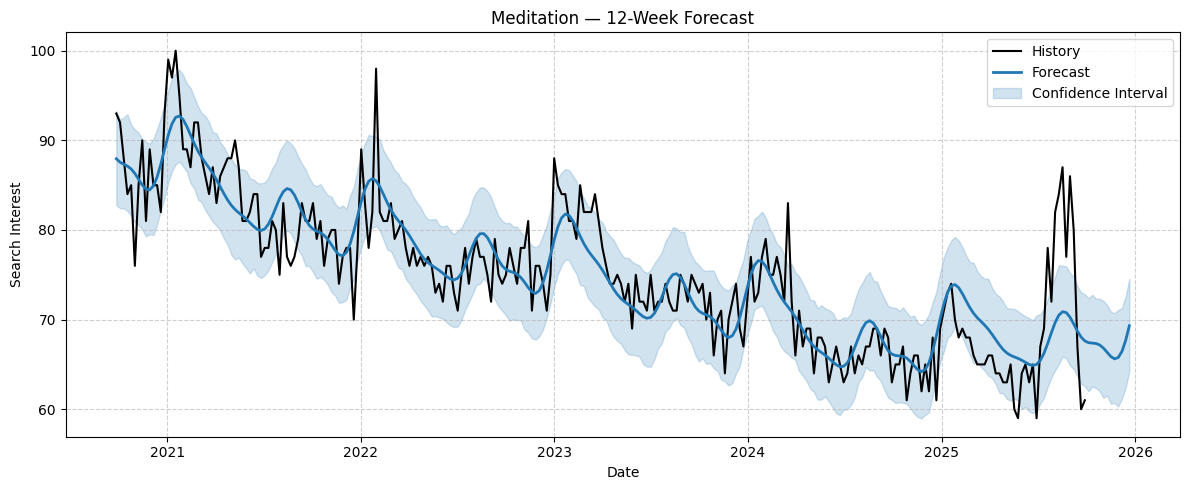

In [8]:
# Purpose: Plot historical data with forecast for one keyword

def plot_forecast(
    df: pd.DataFrame,
    df_forecast: pd.DataFrame,
    keyword: str,
    horizon: int,
) -> None:
    """
    Plot historical interest data with Prophet forecast and confidence intervals.

    Parameters
    ----------
    df : pd.DataFrame
        Original dataset with columns ['date', 'keyword', 'search_interest'].
    df_forecast : pd.DataFrame
        Forecast results with columns ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'keyword'].
    keyword : str
        Keyword to visualize (case-sensitive match in DataFrame).
    horizon : int
        Forecast horizon in weeks (used in the plot title).
    """
    hist = df.loc[df["keyword"] == keyword]
    fc = df_forecast.loc[df_forecast["keyword"] == keyword]

    if hist.empty or fc.empty:
        raise ValueError(f"No data found for keyword '{keyword}'.")

    plt.figure(figsize=(12, 5))
    plt.plot(
        hist["date"], hist["search_interest"],
        label="History", color="black", linewidth=1.5
    )
    plt.plot(
        fc["ds"], fc["yhat"],
        label="Forecast", color="tab:blue", linewidth=2
    )
    plt.fill_between(
        fc["ds"], fc["yhat_lower"], fc["yhat_upper"],
        color="tab:blue", alpha=0.2, label="Confidence Interval"
    )

    plt.title(f"{keyword.title()} — {horizon}-Week Forecast")
    plt.xlabel("Date")
    plt.ylabel("Search Interest")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


# Example usage (inspection only)
plot_forecast(df_global, df_fc12, "meditation", 12)

### Interpreting the 12-Week Forecast (Meditation)

The plot combines both **historical search interest** (black line) and the **forecasted values** (blue line) for meditation.  
The shaded band represents the confidence interval, showing the range of plausible outcomes.  

From this view, we can see that interest in meditation shows short-term fluctuations but is projected to remain relatively stable over the next 12 weeks.  

---

### Summarizing Forecast Results  

While the plots provide a visual story, it’s also useful to capture the **final forecasted values** in table form.  
Here I summarize the **last point** in each forecast horizon (12-week and 52-week) for all keywords.  

This produces a compact view that highlights the expected level of search interest, along with upper and lower confidence bounds.  
The tables make it easy to compare across keywords and see which practices are projected to hold the strongest interest.  

In [9]:
# Purpose: Summarize the last forecasted value per keyword (with optional rounding/sort)

def summarize_forecasts(
    df_forecast: pd.DataFrame,
    horizon: int,
    *,
    round_cols: bool = False,
    decimals: int = 2,
    sort_desc: bool = False,
) -> pd.DataFrame:
    """
    Summarize the last forecasted point for each keyword.

    Parameters
    ----------
    df_forecast : DataFrame with ['ds','yhat','yhat_lower','yhat_upper','keyword']
    horizon : int
        Horizon in weeks (added as a column).
    round_cols : bool, default False
        If True, rounds yhat/intervals to `decimals`. Defaults keep raw values.
    decimals : int, default 2
        Rounding precision if round_cols=True.
    sort_desc : bool, default False
        If True, sort by yhat descending.

    Returns
    -------
    DataFrame with ['keyword','forecast_date','yhat','yhat_lower','yhat_upper','horizon'].
    """
    if df_forecast.empty:
        raise ValueError("Input forecast DataFrame is empty.")

    summary = (
        df_forecast.groupby("keyword")
        .tail(1)
        .loc[:, ["keyword", "ds", "yhat", "yhat_lower", "yhat_upper"]]
        .rename(columns={"ds": "forecast_date"})
        .reset_index(drop=True)
    )
    summary["horizon"] = int(horizon)

    if round_cols:
        cols = ["yhat", "yhat_lower", "yhat_upper"]
        summary[cols] = summary[cols].round(decimals)

    if sort_desc:
        summary = summary.sort_values("yhat", ascending=False, ignore_index=True)

    return summary


# Summarize 12-week and 52-week forecasts
summary_12w = summarize_forecasts(df_fc12, HORIZON_12W, round_cols=True, decimals=2, sort_desc=True)
summary_52w = summarize_forecasts(df_fc52, HORIZON_52W, round_cols=True, decimals=2, sort_desc=True)

### 12-Week Forecast Summary

The short-term outlook highlights how search interest is expected to evolve over the next three months.  
- **Meditation** remains the dominant keyword with forecasted interest around **67**, far higher than the rest.  
- **Mindfulness** follows with a moderate projection near **19**.  
- **Guided meditation, breathwork, and yoga nidra** show smaller but steady levels, each ranging between **2–4**.  

This snapshot provides a clear view of the near-term demand for these practices, showing that meditation continues to lead significantly in popularity.

In [10]:
style_results_table(summary_12w)

keyword,forecast_date,yhat,yhat_lower,yhat_upper,horizon
meditation,2025-12-21,69.31,64.24,74.55,12
mindfulness,2025-12-21,19.84,17.28,22.24,12
guided meditation,2025-12-21,3.63,3.05,4.18,12
breathwork,2025-12-21,3.59,3.14,4.05,12
yoga nidra,2025-12-21,2.93,2.49,3.38,12


### 52-Week Forecast Summary

The long-term horizon shows how trends are projected to sustain over the coming year.  
- **Meditation** again leads with an expected interest of about **68**, underscoring its lasting dominance.  
- **Mindfulness** holds second place with a forecast near **24**.  
- **Guided meditation, breathwork, and yoga nidra** remain stable at lower levels, clustered between **3–4**.  

The year-ahead projection reinforces the hierarchy seen in the short-term, where meditation is consistently on top, followed by mindfulness, with niche practices maintaining smaller but reliable interest.

In [11]:
style_results_table(summary_52w)

keyword,forecast_date,yhat,yhat_lower,yhat_upper,horizon
meditation,2026-09-27,69.10,63.83,74.20,52
mindfulness,2026-09-27,25.00,22.45,27.50,52
breathwork,2026-09-27,4.38,3.90,4.83,52
guided meditation,2026-09-27,4.08,3.50,4.66,52
yoga nidra,2026-09-27,3.16,2.68,3.60,52


## Conclusion

This forecasting exercise adds a forward-looking dimension to my project.  
By applying **Prophet** to Google Trends data, I was able to extend the analysis beyond describing historical patterns into projecting how interest may evolve in the future.  

The results align with expectations:  
- **Meditation** continues to lead by a wide margin, with stable forecasts across both 12-week and 52-week horizons.  
- **Mindfulness** holds the second spot, reflecting its strong presence as a complementary practice.  
- **Guided meditation, breathwork, and yoga nidra** remain smaller but steady in global interest, showing consistent demand within niche audiences.  

The forecasts are not meant to be perfect predictions, but rather to demonstrate the ability to:  
- Clean and prepare real-world time series data  
- Configure and validate a forecasting model through backtesting  
- Present short-term and long-term projections in a clear, interpretable format  

This final step rounds out the project by showing how **predictive analytics** can be applied to behavioral trend data.  
It highlights both technical skills (modeling, validation, visualization) and the ability to communicate insights clearly — which are essential for any data analyst role.